In [31]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 


In [32]:
df =  pd.read_csv("DatasetExos2.csv" , delimiter=";")
to_numeric = ["Acc_x","Acc_y","Acc_z","Gyro_x","Gyro_y","Gyro_z","Set"]
for i in to_numeric:
    df[i]=pd.to_numeric(df[i],errors="coerce")
df= df.dropna()
df = df.drop(columns=["ep (ms)" , "ID" , "Label"])

In [33]:
columns = df.columns[:]
def hamming(string1 , string2):
    minimum = min(len(string1) , len(string2))
    count = 0 
    for i in range(minimum):
        if string1[i] != string2[i]:
            count+=1
    return count + abs(len(string1) - len(string2))

def manhatten(atr1 , atr2):
    return abs(atr1 - atr2)

def distance(df,index , instance , index_inst):
    dist = 0
    for col in columns:
        if df[col].dtype == "object":
            try:
                dist += hamming(df.iloc[index][col], instance.iloc[index_inst][col])
            except ValueError:
                print(f"Warning: Hamming distance error for column '{col}'. Treating as max distance.")
        else:
            try:
                dist += manhatten(df.iloc[index][col], instance.iloc[index_inst][col])
            except ValueError:
                print(f"Warning: Hamming distance error for column '{col}'. Treating as max distance.")
    return dist

In [34]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

def calculate_centroid(df, categorical_features ,  number_clusters):
    # Preprocess the dataset
    numeric_features = [col for col in df.columns if col not in categorical_features]
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features)
        ]
    )

    #transforme the dataset
    processed_data = preprocessor.fit_transform(df)
    processed_df = pd.DataFrame(processed_data)

    #random centroids from the dataet
    centroids = processed_df.sample(n=number_clusters, random_state=42)
    clusters = [0] * len(processed_df)

    while True:
        old_centroids = centroids.copy()

        # Assign each instance to the closest centroid
        for i in range(len(processed_df)):
            min_distance = float('inf')
            for j in range(len(centroids)):
                dist = np.linalg.norm(processed_df.iloc[i] - centroids.iloc[j])
                if min_distance > dist:
                    min_distance = dist
                    clusters[i] = j

        # Recalculate centroids based on the mean of assigned instances
        new_centroids = []
        for k in range(number_clusters):
            cluster_points = processed_df.iloc[[idx for idx, cluster in enumerate(clusters) if cluster == k]]
            if not cluster_points.empty:
                new_centroids.append(cluster_points.mean())
            else:
                # Handle empty clusters by reinitializing
                new_centroids.append(centroids.iloc[k])

        centroids = pd.DataFrame(new_centroids)

        # Check for convergence
        if centroids.equals(old_centroids):
            break

    print(clusters)
    print(len(clusters))
    return clusters , processed_df

def kmean_algo(df , num_clusters):
    df["cluster"] , df_processes = calculate_centroid(df , ["Category"], 6)

    if 'Category' in df.columns:
        label_encoder = LabelEncoder()
        df['Category_encoded'] = label_encoder.fit_transform(df['Category'])

    # 2. Prepare the numeric data for K-Means (drop non-numeric columns)
    numeric_df = df.drop(columns=['Category', 'cluster'], errors='ignore')  # Drop non-numeric columns
    numeric_df = numeric_df.select_dtypes(include=['number'])  # Keep only numeric data

    # 3. Apply the K-Means algorithm
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)  # 3 clusters for demonstration
    kmeans.fit(numeric_df)

    # Add the cluster labels to the original DataFrame
    return kmeans.labels_

def plot_pca_clusters(df):
    features = df.drop(columns=['cluster', 'Category', 'Set'])  # Drop non-numerical columns
    clusters = df['cluster']

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    # Create a new DataFrame for PCA results
    pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
    pca_df['cluster'] = clusters

    # Plot the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='PCA1', 
        y='PCA2', 
        hue='cluster', 
        palette='tab10', 
        data=pca_df, 
        s=100
    )
    plt.title("PCA Visualization of Clusters (2D)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster")
    plt.show()

[3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 4, 3, 4, 4, 3, 0, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 4, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 4, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 4, 4, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 3, 4, 3, 0, 3, 0, 0, 3, 4, 0, 3, 3, 0, 4, 4, 0, 4, 3, 3, 0, 3, 3, 4, 0, 4, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 0, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 3, 3, 4, 4, 0, 3, 3, 4, 3, 0, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 0, 4, 4, 3, 0, 3, 3, 4, 3, 0, 0, 4, 3, 0, 4, 0, 3, 4, 0, 0, 4, 0, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 3, 4, 3, 3, 0, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 0, 0, 3, 4, 3, 0, 3, 3, 3, 4, 0, 4, 3, 3, 0, 4, 3, 3, 3, 4, 4, 3, 0, 0, 3, 3, 0, 3, 4, 4, 3, 4, 3, 4, 0, 0, 4, 0, 3, 4, 4, 3, 3, 3, 0, 3, 3, 3, 3, 0, 0, 3, 4, 3, 3, 3, 4, 3, 3, 0, 3, 3, 3, 4, 4, 3, 3, 3, 0, 0, 3, 3, 0, 0, 4, 4, 3, 0, 0, 4, 3, 3, 3, 3, 4, 4, 0, 4, 4, 0, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 4, 4, 3, 3, 4, 4, 0, 4, 4, 3, 3, 4, 4, 3, 0, 

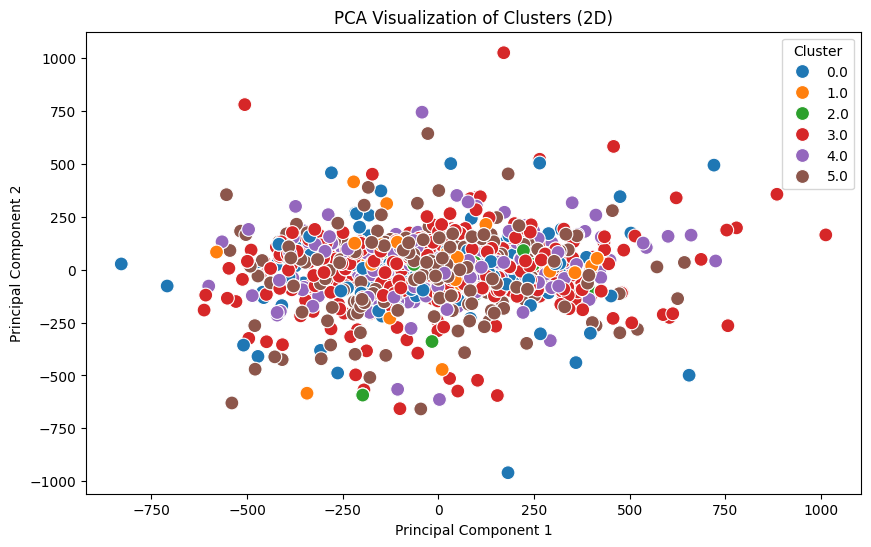

[3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 4, 3, 4, 4, 3, 0, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 4, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 4, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 4, 4, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 3, 4, 3, 0, 3, 0, 0, 3, 4, 0, 3, 3, 0, 4, 4, 0, 4, 3, 3, 0, 3, 3, 4, 0, 4, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 0, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 3, 3, 4, 4, 0, 3, 3, 4, 3, 0, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 0, 4, 4, 3, 0, 3, 3, 4, 3, 0, 0, 4, 3, 0, 4, 0, 3, 4, 0, 0, 4, 0, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 3, 4, 3, 3, 0, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 0, 0, 3, 4, 3, 0, 3, 3, 3, 4, 0, 4, 3, 3, 0, 4, 3, 3, 3, 4, 4, 3, 0, 0, 3, 3, 0, 3, 4, 4, 3, 4, 3, 4, 0, 0, 4, 0, 3, 4, 4, 3, 3, 3, 0, 3, 3, 3, 3, 0, 0, 3, 4, 3, 3, 3, 4, 3, 3, 0, 3, 3, 3, 4, 4, 3, 3, 3, 0, 0, 3, 3, 0, 0, 4, 4, 3, 0, 0, 4, 3, 3, 3, 3, 4, 4, 0, 4, 4, 0, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 4, 4, 3, 3, 4, 4, 0, 4, 4, 3, 3, 4, 4, 3, 0, 

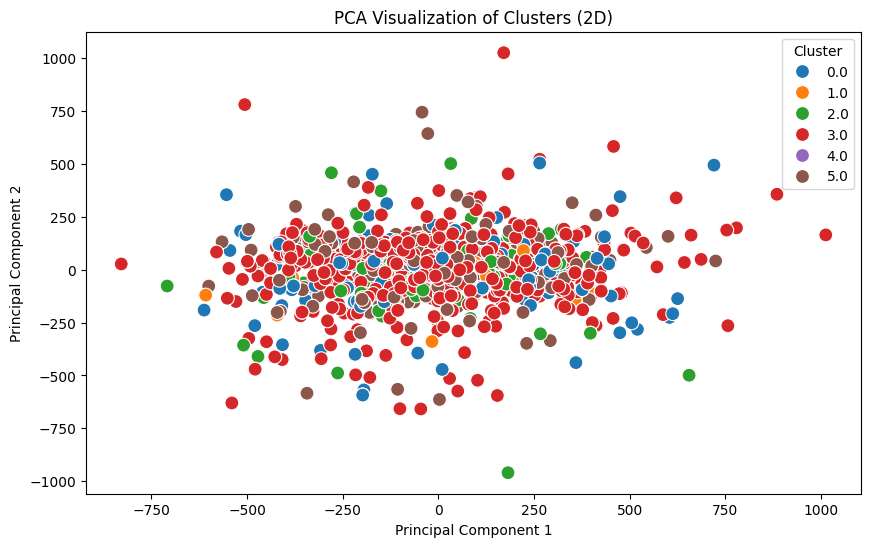

In [35]:
df["cluster"] , df_processes = calculate_centroid(df , ["Category"], 6)
plot_pca_clusters(df)
df =df.drop(columns=["cluster"])
df["cluster"] = kmean_algo(df , 6)
plot_pca_clusters(df)

[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

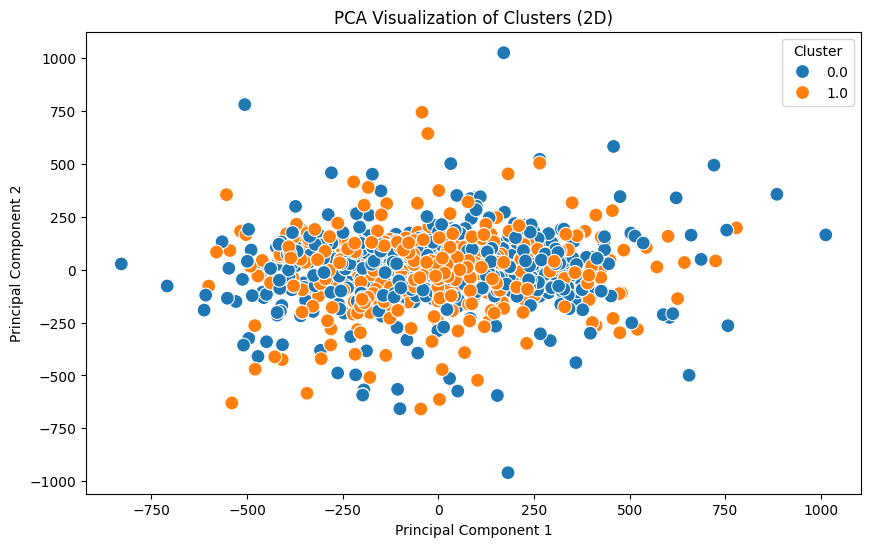

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 0, 4, 4, 0, 4, 0, 4, 4, 0, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 0, 4, 4, 0, 0, 4, 0, 0, 4, 4, 0, 4, 4, 0, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 0, 0, 4, 4, 4, 0, 0, 4, 4, 0, 4, 0, 4, 4, 0, 0, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 0, 4, 4, 4, 0, 0, 0, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 4, 0, 0, 4, 4, 4, 0, 0, 4, 0, 4, 0, 4, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 0, 

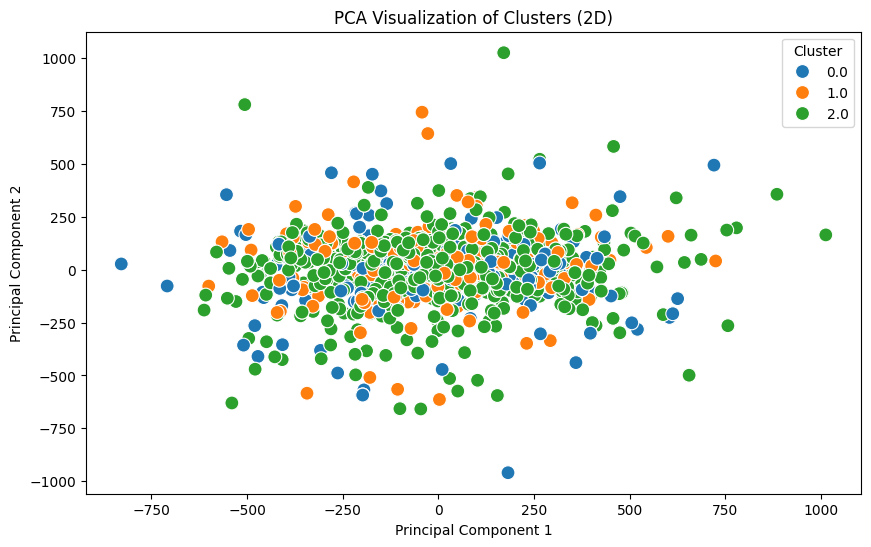

In [36]:
df =df.drop(columns=["cluster"])
df["cluster"] , df_processes = calculate_centroid(df , ["Category"], 3)
plot_pca_clusters(df)
df =df.drop(columns=["cluster"])
df["cluster"] = kmean_algo(df , 3)
plot_pca_clusters(df)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 0, 4, 4, 0, 4, 0, 4, 4, 0, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 0, 4, 4, 0, 0, 4, 0, 0, 4, 4, 0, 4, 4, 0, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 0, 0, 4, 4, 4, 0, 0, 4, 4, 0, 4, 0, 4, 4, 0, 0, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 0, 4, 4, 4, 0, 0, 0, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 4, 0, 0, 4, 4, 4, 0, 0, 4, 0, 4, 0, 4, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 0, 

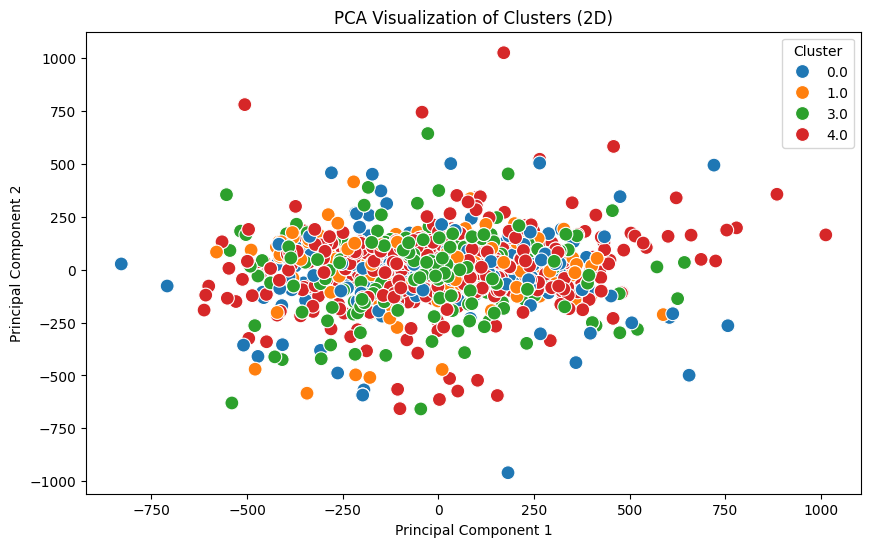

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 0, 4, 4, 0, 4, 0, 4, 4, 0, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 0, 4, 4, 0, 0, 4, 0, 0, 4, 4, 0, 4, 4, 0, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 0, 0, 4, 4, 4, 0, 0, 4, 4, 0, 4, 0, 4, 4, 0, 0, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 0, 4, 4, 4, 0, 0, 0, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 4, 0, 0, 4, 4, 4, 0, 0, 4, 0, 4, 0, 4, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 0, 

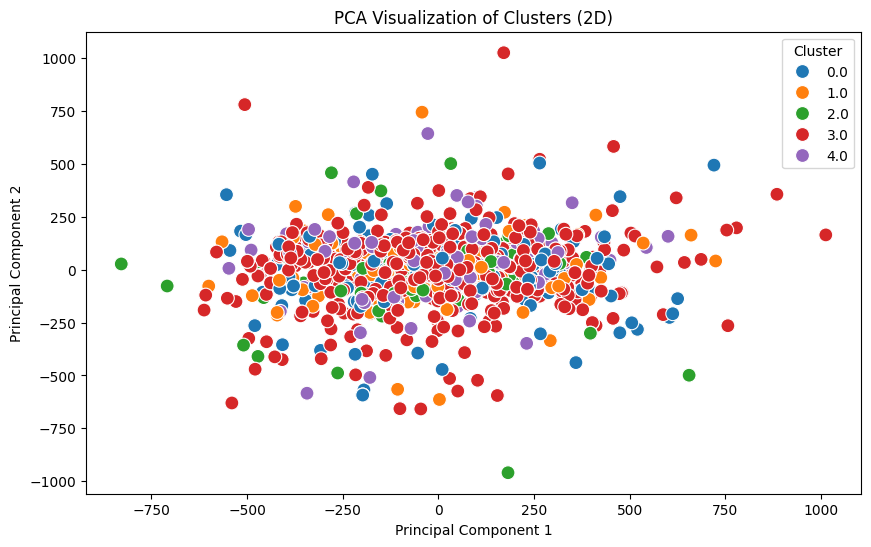

In [37]:
df =df.drop(columns=["cluster"])
df["cluster"] , df_processes = calculate_centroid(df , ["Category"], 5)
plot_pca_clusters(df)
df =df.drop(columns=["cluster"])
df["cluster"] = kmean_algo(df , 5)
plot_pca_clusters(df)